# Social Media Engagement Model

This project explores what drives post-level social media engagement using a using a Kaggle dataset of 731 posts. The goal was to model an **Engagement Score**, defined as:

> **Engagement Score = Likes + (2 × Retweets)**

This weighting reflects the strategic belief that shares (retweets) contribute more to visibility and reach than likes. The project leverages feature engineering, XGBoost + CatBoost modeling, and SHAP explainability to identify the most impactful factors behind engagement.


https://www.kaggle.com/code/ahmedraft/social-media-analysis


## Project Workflow

- **Data Cleaning**  
  Removed duplicates, standardized text fields, and filtered out edge cases (e.g., zero engagement, future timestamps).

- **Feature Engineering**  
  Created variables based on timing, structure, hashtags, and sentiment. Combined features to capture interactions like `Sentiment_HourBin` and `Char_Per_Hashtag_Bin`. 

- **Model Training**  
  Trained and tuned a CatBoost Regressor using Repeated K-Fold CV. XGBoost was also explored, but CatBoost offered better generalization and cleaner interpretability.

- **Explainability**  
  Used SHAP to evaluate feature contributions and guide refinement. Unimportant features were dropped or restructured.

- **Visualization**  
  Tableau dashboard built for pattern exploration across time, platform, sentiment, and country. Supports SUM/AVG engagement toggling.

## Data Preparation

This section includes standard steps used to prepare, clean, and segment the data for modeling:

- Removed duplicate and near-duplicate posts  
- Standardized categorical fields (e.g., sentiment, country, platform)
- Basic integrity and behavioral checks
- Segmented sentiment and country to assess value of granularity vs. general trends
 

In [23]:
import pandas as pd
import numpy as np
import re
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from xgboost import XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [25]:
df = pd.read_csv("sentiment_dataset.csv")

print("Row count:", len(df))
df.info()
df.head()

# Null check
print("\nNull values:\n", df.isnull().sum())

# Unique Counts of Columns
for col in df.columns:
    print(col, df[col].nunique())

# Duplicate check
print("Duplicate rows:", df.duplicated().sum())
display(df[df.duplicated(keep=False)].sort_values(by=df.columns.tolist()).head(6))

Row count: 732
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       732 non-null    object
 1   Sentiment  732 non-null    object
 2   Timestamp  732 non-null    object
 3   User       732 non-null    object
 4   Platform   732 non-null    object
 5   Hashtags   732 non-null    object
 6   Retweets   732 non-null    int64 
 7   Likes      732 non-null    int64 
 8   Country    732 non-null    object
 9   Year       732 non-null    int64 
 10  Month      732 non-null    int64 
 11  Day        732 non-null    int64 
 12  Hour       732 non-null    int64 
dtypes: int64(6), object(7)
memory usage: 74.5+ KB

Null values:
 Text         0
Sentiment    0
Timestamp    0
User         0
Platform     0
Hashtags     0
Retweets     0
Likes        0
Country      0
Year         0
Month        0
Day          0
Hour         0
dtype: int64
Text 707
Sentiment 19

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
278,"A compassionate rain, tears of empathy fallin...",Compassionate,2021-07-01 12:10:00,RainNurturer,Instagram,#Compassionate #TearsOfEmpathy,21,42,Canada,2021,7,1,12
292,"A compassionate rain, tears of empathy fallin...",Compassionate,2021-07-01 12:10:00,RainNurturer,Instagram,#Compassionate #TearsOfEmpathy,21,42,Canada,2021,7,1,12
271,"A free spirit soaring on the wings of dreams,...",Free-spirited,2020-06-10 10:05:00,DreamSoarer,Twitter,#FreeSpirit #WingsOfDreams,22,44,UK,2020,6,10,10
285,"A free spirit soaring on the wings of dreams,...",Free-spirited,2020-06-10 10:05:00,DreamSoarer,Twitter,#FreeSpirit #WingsOfDreams,22,44,UK,2020,6,10,10
267,"A playful escapade in the carnival of life, c...",Playful,2018-08-22 17:20:00,CarnivalDreamer,Facebook,#Playful #CarnivalEscapade,24,48,Australia,2018,8,22,17
281,"A playful escapade in the carnival of life, c...",Playful,2018-08-22 17:20:00,CarnivalDreamer,Facebook,#Playful #CarnivalEscapade,24,48,Australia,2018,8,22,17


In [33]:
# Drop dupes
df = df.drop_duplicates().copy()

# Text Count
print("Text count:", df['Text'].count())

# Unique Counts of Columns
for col in df.columns:
    print(col, df[col].nunique())

Text count: 711
Text 707
Sentiment 191
Timestamp 683
User 670
Platform 3
Hashtags 692
Retweets 26
Likes 38
Country 33
Year 14
Month 12
Day 31
Hour 22


In [35]:
potential_duplicates = df[df.duplicated(subset=['Text'], keep=False)]
display(potential_duplicates.sort_values(by=df.columns.tolist()))

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
264,"A compassionate rain, tears of empathy fallin...",Compassionate,2021-07-01 12:10:00,RainNurturer,Facebook,#Compassionate #TearsOfEmpathy,21,42,Canada,2021,7,1,12
278,"A compassionate rain, tears of empathy fallin...",Compassionate,2021-07-01 12:10:00,RainNurturer,Instagram,#Compassionate #TearsOfEmpathy,21,42,Canada,2021,7,1,12
329,"Dismissive gestures, a curtain drawn to shiel...",Dismissive,2018-08-18 14:00:00,IndifferentFort,Instagram,#Dismissive #IndifferencePerformance,12,24,Australia,2018,8,18,14
317,"Dismissive gestures, a curtain drawn to shiel...",Dismissive,2018-08-18 14:40:00,CurtainShield,Instagram,#Dismissive #IndifferencePerformance,12,24,Australia,2018,8,18,14
294,"Embraced by the hopeful dawn, a gardener sowi...",Hopeful,2022-07-17 6:15:00,DawnGardener,Instagram,#Hopeful #SeedsOfOptimism,14,28,India,2022,7,17,6
266,"Embraced by the hopeful dawn, a gardener sowi...",Hopeful,2022-07-17 6:15:00,DawnGardener,Instagram,#Hopeful #SeedsOfOptimism,14,28,UK,2022,7,17,6
308,Shattered dreams lie on the floor like fragme...,Frustrated,2022-01-07 11:10:00,DreamMosaic,Instagram,#Frustrated #MosaicOfDisappointment,15,30,Canada,2022,1,7,11
330,Shattered dreams lie on the floor like fragme...,Frustrated,2022-01-07 11:10:00,DreamMosaic,Twitter,#Frustrated #MosaicOfDisappointment,15,30,Canada,2022,1,7,11




> *minimal display of "cross posts" and a true cross post is unlikely to have the exact same metrics and data. Assuming error, dropping*



In [42]:
# Drop noted
df = df.drop_duplicates(subset=['Text']).copy()
print("Text count:", df['Text'].count())

# Unique Counts of Columns
for col in df.columns:
    print(col, df[col].nunique())

# Clean text columns
df['Sentiment'] = df['Sentiment'].str.strip()
df['Platform'] = df['Platform'].str.strip().str.title()
df['Country'] = df['Country'].str.strip()

# Display cleaned unique values with count
def show_unique_values(df, columns):
    for col in columns:
        unique_vals = sorted(df[col].dropna().unique())
        print(f"\n{col} — {len(unique_vals)} unique value(s):")
        print(", ".join(unique_vals))
show_unique_values(df, ['Platform', 'Sentiment', 'Country'])

# Check for negative or zero engagement
print("Negative likes:", df[df['Likes'] < 0].shape[0])
print("Negative retweets:", df[df['Retweets'] < 0].shape[0])
print("Zero engagement rows:", df[(df['Likes'] == 0) & (df['Retweets'] == 0)].shape[0])

# Timestamps in the future
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  
future_dates = df[df['Timestamp'] > pd.Timestamp.today()]
print("Future-dated rows:", future_dates.shape[0])

# Validate individual time values
invalid_hours = df[~df['Hour'].between(0, 23)]
invalid_months = df[~df['Month'].between(1, 12)]
invalid_years = df[~df['Year'].between(2000, 2024)]
print("Invalid hour values:", invalid_hours.shape[0])
print("Invalid month values:", invalid_months.shape[0])
print("Invalid year values:", invalid_years.shape[0])

# Check absurdly high likes/retweets
print("Max Likes:", df['Likes'].max())
print("Max Retweets:", df['Retweets'].max())

# View post count by user count
user_post_counts = df['User'].value_counts()
posts_per_user_distribution = user_post_counts.value_counts().sort_index()
distribution_df = posts_per_user_distribution.rename_axis('Number of Posts').reset_index(name='Number of Users')
display(distribution_df)

Text count: 707
Text 707
Sentiment 191
Timestamp 682
User 670
Platform 3
Hashtags 692
Retweets 26
Likes 38
Country 33
Year 14
Month 12
Day 31
Hour 22

Platform — 3 unique value(s):
Facebook, Instagram, Twitter

Sentiment — 191 unique value(s):
Acceptance, Accomplishment, Admiration, Adoration, Adrenaline, Adventure, Affection, Amazement, Ambivalence, Amusement, Anger, Anticipation, Anxiety, Appreciation, Apprehensive, Arousal, ArtisticBurst, Awe, Bad, Betrayal, Bitter, Bitterness, Bittersweet, Blessed, Boredom, Breakthrough, Calmness, Captivation, Celebration, Celestial Wonder, Challenge, Charm, Colorful, Compassion, Compassionate, Confidence, Confident, Confusion, Connection, Contemplation, Contentment, Coziness, Creative Inspiration, Creativity, Culinary Adventure, CulinaryOdyssey, Curiosity, Darkness, Dazzle, Desolation, Despair, Desperation, Determination, Devastated, Disappointed, Disappointment, Disgust, Dismissive, DreamChaser, Ecstasy, Elation, Elegance, Embarrassed, Emotion, E

,Number of Posts,Number of Users
0,1,635
1,2,33
2,3,2


In [44]:
# Create Engagement Score
df['Engagement_Score'] = df['Likes'] + (2 * df['Retweets'])

# Create Sentiment Grouped
top_sentiments = df['Sentiment'].value_counts()[lambda x: x > 8].index
df['Sentiment_Grouped'] = df['Sentiment'].apply(lambda x: x if x in top_sentiments else 'Other')

# Group Rare Countries 
top_countries = df['Country'].value_counts()[lambda x: x > 20].index
df['Country_Grouped'] = df['Country'].apply(lambda x: x if x in top_countries else 'Other')

# Create Post Character Count
df['Post_Char_Count'] = df['Text'].astype(str).apply(len)

## Feature Engineering

- Engineered interaction features such as `Sentiment_Hour`, `Char_Per_Hashtag_Hour`, and `Sentiment_Daypart`.
- All interactions made throughout modeling were moved here for simpliifying notebook.

In [47]:

# Bin Post Length by Character Count
bins = [0, 60, 100, float('inf')]
labels = ['Short', 'Medium', 'Long']
df['Post_Length_Bin'] = pd.cut(df['Post_Char_Count'], bins=bins, labels=labels)

# Extract hashtags from text
def extract_hashtags_from_text(text):
    hashtags = re.findall(r'(?:^|\s)(#\w+)', str(text))
    return set([tag.title() for tag in hashtags]) 

# Extract hashtags from column
def extract_hashtags_from_column(hashtags):
    if pd.isna(hashtags):
        return set()
    return set([tag.strip().title() for tag in str(hashtags).split()])
    
# Count hashtags from column
def count_hashtags(val):
    if pd.isna(val):
        return 0
    return len(re.split(r'[,\s]+', str(val).strip()))
df['Hashtag_Count'] = df['Hashtags'].apply(count_hashtags)

# Count hashtags from text different from column
def count_additional_text_hashtags(row):
    text_tags = extract_hashtags_from_text(row['Text'])
    column_tags = extract_hashtags_from_column(row['Hashtags'])
    unique_to_text = text_tags - column_tags  # set difference
    return len(unique_to_text)
    
def get_text_only_hashtags(row):
    text_tags = extract_hashtags_from_text(row['Text'])
    column_tags = extract_hashtags_from_column(row['Hashtags'])
    return list(text_tags - column_tags)  # only new ones from text
    
df['Text_Only_Hashtags'] = df.apply(get_text_only_hashtags, axis=1)
df['Hashtag_Count_from_Text'] = df.apply(count_additional_text_hashtags, axis=1)
df['Hashtag_Count_Total'] = df['Hashtag_Count_from_Text'] + df['Hashtag_Count_Total']
df['Char_Per_Hashtag'] = df['Post_Char_Count'] / df['Hashtag_Count_Total']

# Create Daypart Column
def get_daypart_3hr_am_pm(hour):
    if 0 <= hour < 3:
        return '12-03 AM'
    elif 3 <= hour < 6:
        return '03-06 AM'
    elif 6 <= hour < 9:
        return '06-09 AM'
    elif 9 <= hour < 12:
        return '09-12 AM'
    elif 12 <= hour < 15:
        return '12-03 PM'
    elif 15 <= hour < 18:
        return '03-06 PM'
    elif 18 <= hour < 21:
        return '06-09 PM'
    else:
        return '09-12 PM'
df['Daypart'] = df['Hour'].apply(get_daypart_3hr_am_pm)

# Create Day of Week
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Day_of_Week'] = df['Timestamp'].dt.day_name()

# Create Character Per Hashtag Bin
bins = [0, 30, 40, float('inf')]
labels = ['Short', 'Optimal', 'Long']
df['Char_Per_Hashtag_Bin'] = pd.cut(df['Char_Per_Hashtag'], bins=bins, labels=labels)

# Create Hour Bin (Night, Morning, etc.)
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df['Hour_Bin'] = pd.cut(df['Hour'], bins=bins, labels=labels, right=False)

# Create Custom Time Block (5-9AM = Morning, etc.)
def assign_time_block(hour):
    if 5 <= hour <= 9:
        return 'Morning'        # 5 AM to 9 AM
    elif 10 <= hour <= 13:
        return 'Midday'         # 10 AM to 1 PM
    elif 14 <= hour <= 17:
        return 'Afternoon'      # 2 PM to 5 PM
    elif 18 <= hour <= 21:
        return 'Evening'        # 6 PM to 9 PM
    else:
        return 'Late_Night'     # 10 PM to 4 AM
df['Time_Block'] = df['Hour'].apply(assign_time_block)
df['Time_Block'] = df['Time_Block'].astype(str)

# Create Sentiment-Time Interaction Features
df['Sentiment_Hour'] = df['Sentiment'].astype(str) + "_H" + df['Hour'].astype(str)
df['Sentiment_Daypart'] = df['Sentiment'].astype(str) + "_" + df['Daypart'].astype(str)

# Create Sentiment-Hour Bin Interaction
df['Sentiment_HourBin'] = df['Sentiment'].astype(str) + "_" + df['Hour_Bin'].astype(str)

# Create Interaction Features (Hashtag and Time)
df['Char_Per_Hashtag_Hour'] = df['Char_Per_Hashtag'].astype(str) + "_H" + df['Hour'].astype(str)
df['HashtagBin_Hour'] = df['Char_Per_Hashtag_Bin'].astype(str) + "_H" + df['Hour'].astype(str)

def assign_season(month):
    # Just ensure month is an integer 1-12
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
df['Season'] = df['Month'].apply(assign_season)

# Example: create Sentiment x Platform
df['Sentiment_Platform'] = df['Sentiment'].astype(str) + "_" + df['Platform'].astype(str)

# Example: create Sentiment x Season
df['Sentiment_Season'] = df['Sentiment'].astype(str) + "_" + df['Season'].astype(str)

# Example: create Sentiment x Time_Block
df['Sentiment_Time_Block'] = df['Sentiment'].astype(str) + "_" + df['Time_Block'].astype(str)

# Example: create Sentiment x Char_Per_Hashtag_Bin
df['Sentiment_Char_Per_Hashtag_Bin'] = (
    df['Sentiment'].astype(str) 
    + "_" 
    + df['Char_Per_Hashtag_Bin'].astype(str)
)

## Modeling and Explainability

After testing multiple variations of XGBoost and CatBoost on a dataset of 707 social media posts, **the highest-performing model was a tuned CatBoost regressor, achieving a test R² score of 0.3442 (Train R² = 0.5479).** A closely competing XGBoost model followed with a test R² of 0.3302 (Train R² = 0.7202). CatBoost ultimately delivered better generalization due to a smaller gap between training and test performance.

**Feature engineering played a pivotal role in elevating CatBoost’s accuracy.** Variables like Post_Char_Count, Char_Per_Hashtag_Bin, Time_Block, and Sentiment_Char_Per_Hashtag_Bin consistently ranked among the most impactful features.
The inclusion of interaction terms like Sentiment_Char_Per_Hashtag_Bin measurably improved the model’s performance.

That said, overall predictive power remained modest. This reflects the dataset’s limitations: engagement metrics don't reflect real-world numbers, there's no user-level context, and no media types. Still, the models successfully extracted directional signals. **These findings are exploratory and dataset-specific, not representative of broader real-world social media behavior.**

**In a more robust dataset with behavioral tracking and richer metadata, a similar modeling approach could prove far more predictive and reliable.** The workflow itself provides a strong foundation for future engagement forecasting and content strategy analysis.

---

## Visualization

Alongside the regression modeling, an interactive Tableau dashboard was built to explore how different features interact and influence engagement.

The dashboard allows users to filter by sentiment, country, platform, time of day, and more, making it easy to analyze patterns.


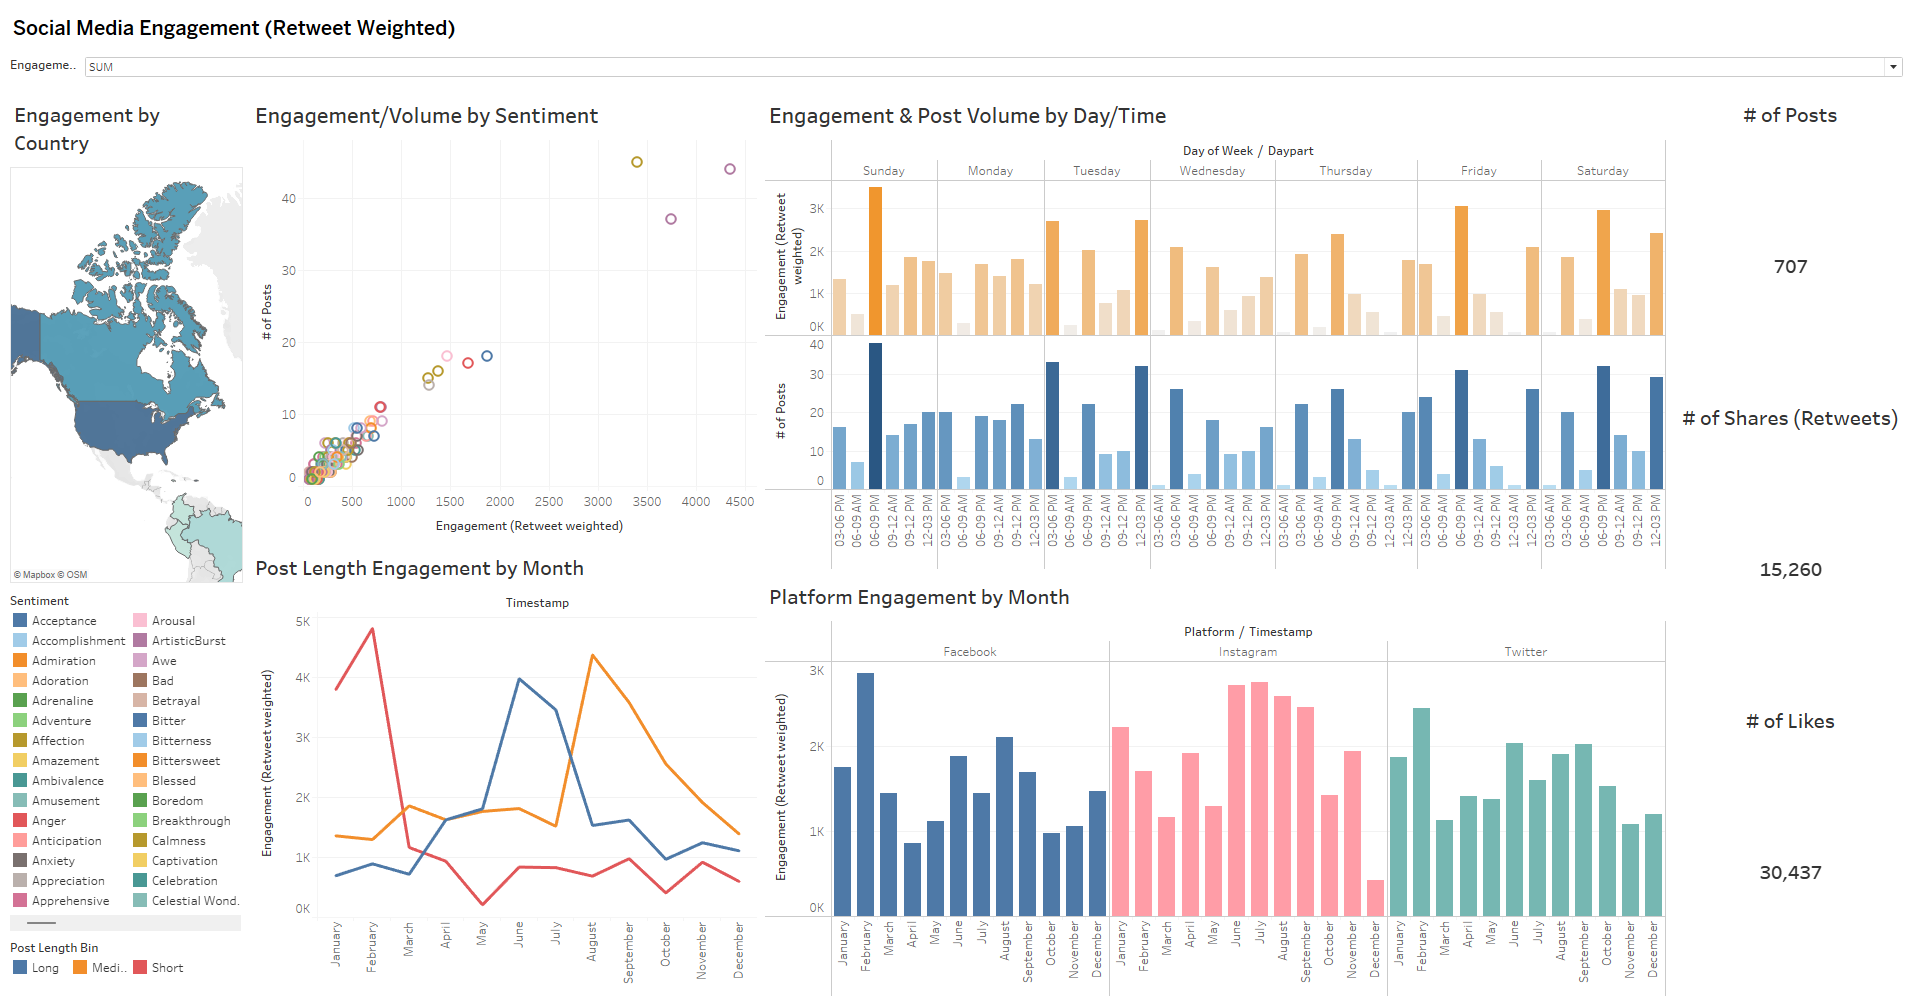



**Link to dashboard:** 

https://public.tableau.com/views/SocialMediaEngagementRetweetWeighted/Story1?:language=enUS&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link



--

**Predictive Models**

---

**Best CatBoost Model**

---

Fitting 6 folds for each of 30 candidates, totalling 180 fits
Best Parameters: {'subsample': 0.9, 'random_strength': 1, 'learning_rate': 0.02, 'l2_leaf_reg': 5, 'iterations': 600, 'depth': 4}
Test MSE: 531.97
Test R² Score: 0.3442
Train R² Score: 0.5479


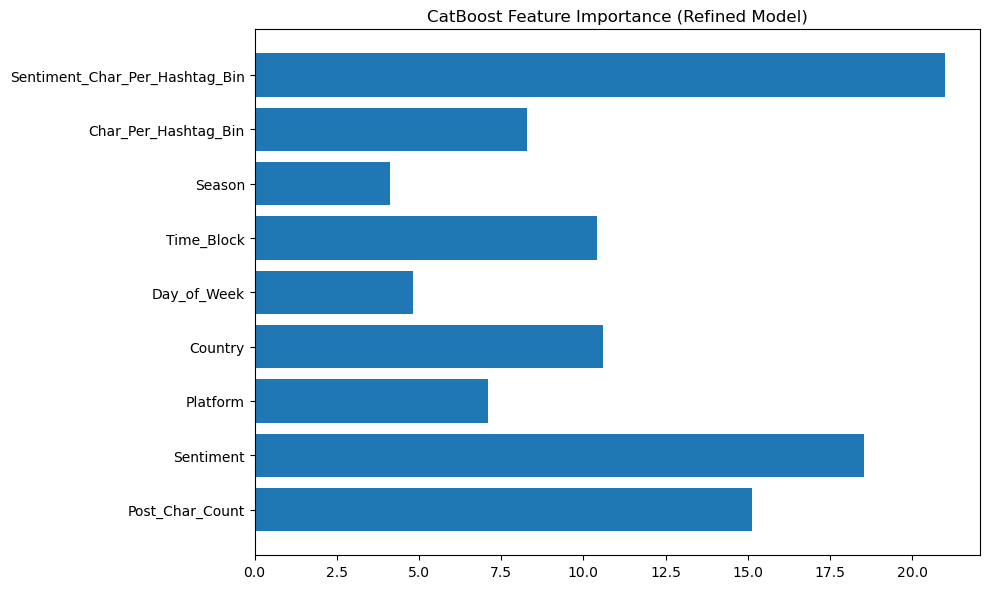

In [82]:

# ------------------------------------------------
# Data Prep
# ------------------------------------------------
df = df.copy()  # Safety


features = [
    'Post_Char_Count', 'Sentiment', 'Platform', 
    'Country', 'Day_of_Week', 'Time_Block', 'Season',

    
    'Char_Per_Hashtag_Bin', 'Sentiment_Char_Per_Hashtag_Bin',
]

target = 'Engagement_Score'


categorical_features = [
    'Sentiment', 'Platform', 'Country', 
    'Day_of_Week', 'Time_Block', 'Season', 
    
    'Char_Per_Hashtag_Bin', 'Sentiment_Char_Per_Hashtag_Bin'

]

for col in categorical_features:
    df[col] = df[col].astype(str)

X = df[features]
y = df[target].copy()


# ------------------------------------------------
# Split into Train/Test
# ------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------------------
# CatBoost Setup + Cross Validation
# ------------------------------------------------
cat_model = CatBoostRegressor(
    loss_function='RMSE',  
    random_seed=42,
    verbose=0  
)


param_dist = {
    'iterations': [600, 700],      
    'depth': [4, 6, 7],
    'learning_rate': [0.01, 0.02],
    'l2_leaf_reg': [1, 5],    
    'subsample': [0.8, 0.9],
    'random_strength': [1, 2, 3]         
}

cv = RepeatedKFold(n_splits=3, n_repeats=2, random_state=42)

grid_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=30,            
    scoring='r2',        
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# ------------------------------------------------
# Train Using CV to Find Best Hyperparams
# ------------------------------------------------
grid_search.fit(
    X_train,
    y_train,
    cat_features=categorical_features
)


best_cat = grid_search.best_estimator_

# ------------------------------------------------
# Evaluate on the Test Set (Completely Unseen)
# ------------------------------------------------
best_cat = grid_search.best_estimator_
y_pred = best_cat.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, best_cat.predict(X_train))

print("Best Parameters:", grid_search.best_params_)
print(f"Test MSE: {mse:.2f}")
print(f"Test R² Score: {r2_test:.4f}")
print(f"Train R² Score: {r2_train:.4f}")

# --------------------------------
# Plot Feature Importance
# --------------------------------
feature_importances = best_cat.get_feature_importance()
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.title("CatBoost Feature Importance (Refined Model)")
plt.tight_layout()
plt.show()

---

**Best XGBoost Model**

---

Fitting 6 folds for each of 16 candidates, totalling 96 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 350, 'subsample': 0.9}
Test Mean Squared Error: 543.36
Test R² Score: 0.3302
Train R² Score: 0.7202


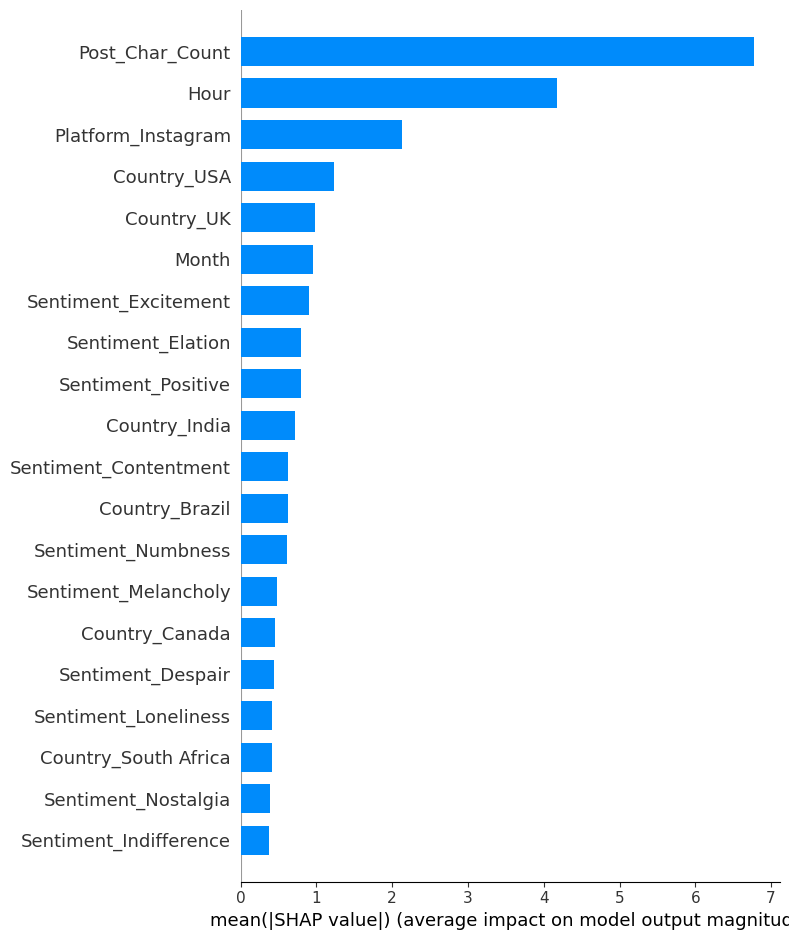

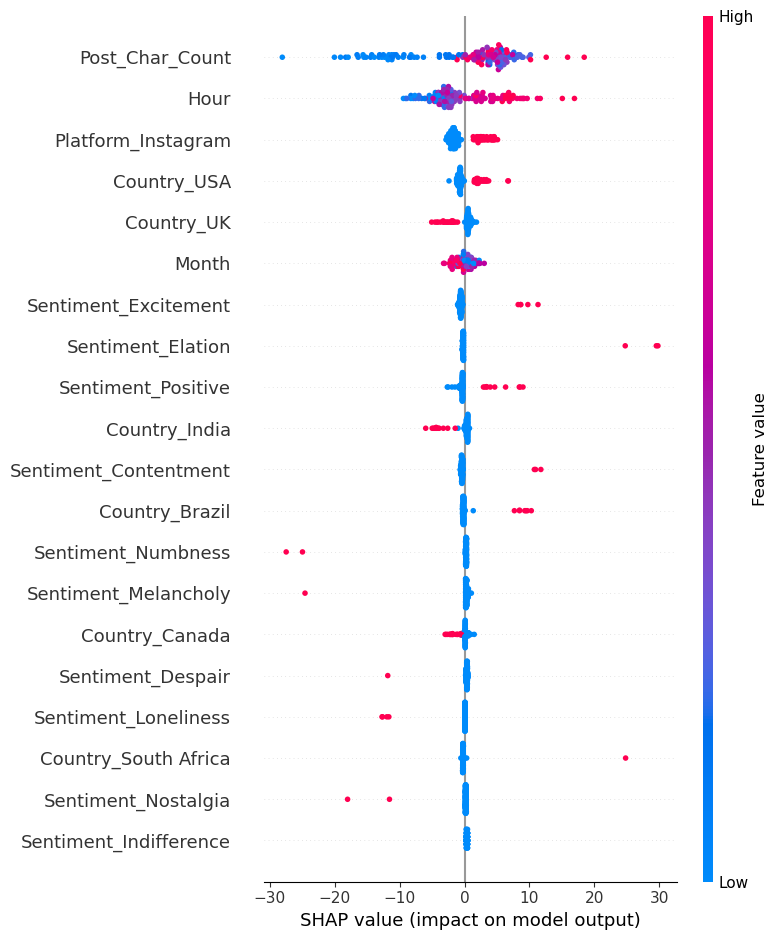

In [78]:
# -----------------------------
# Define Feature Set
# -----------------------------
features = [
    'Post_Char_Count','Sentiment', 'Platform', 
    'Country', 'Month', 'Hour',
]

target = 'Engagement_Score'

X = df[features]
y = df[target]


# -----------------------------
# Train-Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# -----------------------------
# One-Hot Encode + Align Columns
# -----------------------------
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

X_train_encoded, X_test_encoded = X_train_encoded.align(
    X_test_encoded, join='outer', axis=1, fill_value=0
)


# -----------------------------
# XGBoost with RandomizedSearchCV
# -----------------------------

param_grid = {
    'n_estimators': [300, 350],
    'max_depth': [3, 5],
    'learning_rate': [0.02, 0.04],
    'subsample': [0.9],
    'colsample_bytree': [0.7, 0.8],

}

xgb_reg = XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42)


grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='r2',
    cv=RepeatedKFold(n_splits=3, n_repeats=2, random_state=42),
    n_jobs=-1,
    verbose=1
)

# -----------------------------
# Train Model
# -----------------------------
grid_search.fit(X_train_encoded, y_train)

# -----------------------------
# Evaluate
# -----------------------------
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_encoded)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print(f"Test Mean Squared Error: {mse:.2f}")
print(f"Test R² Score: {r2:.4f}")
r2_train = r2_score(y_train, best_model.predict(X_train_encoded))
print(f"Train R² Score: {r2_train:.4f}")


# Initialize TreeExplainer
explainer = shap.Explainer(best_model)

# Compute SHAP values on test data
shap_values = explainer(X_test_encoded)

# Summary Plot 
shap.summary_plot(shap_values, X_test_encoded, plot_type="bar")

# Summary Plot
shap.summary_plot(shap_values, X_test_encoded)